In [1]:
"""
1. preprocessing data
2. build model
2.1 encoder
2.2 attention
2.3 decoder
2.4 optimizer & loss
2.5 train
3.evalution
3.1 given sentence, return translated result
3.2 visualize results(attention)
"""

'\n1. preprocessing data\n2. build model\n2.1 encoder\n2.2 attention\n2.3 decoder\n2.4 optimizer & loss\n2.5 train\n3.evalution\n3.1 given sentence, return translated result\n3.2 visualize results(attention)\n'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.16.2
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
en_spa_file_path = "./data/spa-eng/spa.txt"

import unicodedata
# 转成asc是为了减小词表
def unicode_to_ascii(s):
    # NFD 如果有一个unicode是多个asc组成的，就把这个拆开， Mn 重音
    return "".join(c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != "Mn")

en_sentence = "Put it on"
sp_sentence = "Ponéoslo"
# 比如é 是一个e和一个重音符号，分开因为重音符号是Mn，所以忽略 所以é => e
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Put it on
Poneoslo


In [5]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    # []任意一个， （）替换操作, \1 本身
    # 标点符号前后加空格
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    # 多余空格变成一个空格
    s = re.sub(r'[" "]+', " ", s)
    # 除了标点符号和字母以外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]+', " ", s)
    # 去掉前后空格
    s = s.rstrip().strip()
    s = '<start> ' + s + ' <end>'
    return s

def make_list(x,y):
    return [x,y]

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> put it on <end>
<start> poneoslo <end>


In [6]:
def parse_data(filename):
    lines = open(filename, encoding="UTF-8").read().strip().split("\n")
    sentence_pairs = [line.split("\t")[0:-1] for line in lines]
    preprocessed_sentence_pairs = [ (preprocess_sentence(en),preprocess_sentence(sp)) for en, sp  in sentence_pairs]
    return zip(*preprocessed_sentence_pairs)
en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


In [7]:
# 补充
a = [(1,2), (3,4),(5,6)]
# 单星号能够将这个变量拆分成单个元素
print(*a)
# zip可以转置
c,d = zip(*a)
print(c,d)

(1, 2) (3, 4) (5, 6)
(1, 3, 5) (2, 4, 6)


In [8]:
# 文本式数据要被model读取要变成id式
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words = None, filters="", split=" "
    )
    
    lang_tokenizer.fit_on_texts(lang) 
    #序列的列表，列表中每个序列对应于一段输入文本 
    tensor = lang_tokenizer.texts_to_sequences(lang) #得到词索引[[1, 2, 3, 4], [1, 2, 3, 5]]
    tensor = keras.preprocessing.sequence.pad_sequences(tensor,
                                                   padding = "post")
    return tensor, lang_tokenizer
input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])


def max_length(tensor):
    return max(len(t) for t in tensor)

def len_test(tensor):
    return [len(t) for t in tensor[0:10]]

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)

print(max_length_input, max_length_output)
print(len_test(input_tensor), len_test(output_tensor))
# dir(input_tokenizer)

16 11
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16] [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [9]:
# 切分训练集和验证集
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, 
                                                                      output_tensor, test_size=0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval) 

(24000, 6000, 24000, 6000)

In [10]:
# 验证tokenizer是否起作用
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print("%d --> %s" %(t, tokenizer.index_word[t]))

convert(input_train[1], input_tokenizer)
print()
convert(output_train[1], output_tokenizer)

1 --> <start>
5 --> ¿
22 --> por
11 --> que
16 --> esta
1125 --> enfadada
4 --> ?
2 --> <end>

1 --> <start>
79 --> why
25 --> are
5 --> you
187 --> angry
6 --> ?
2 --> <end>


In [11]:
def make_dataset(input_tensor, output_tensor, 
                 batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, 
                                                 output_tensor))
    if shuffle:
        dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, 
                                           drop_remainder=True)
    return dataset

batch_size = 64
epochs = 20
    
train_dataset = make_dataset(input_train, output_train,
                             batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval,
                             batch_size, 1, False)

In [12]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1   42  349 ...    0    0    0]
 [   1    5   22 ...    0    0    0]
 [   1    5   22 ...    0    0    0]
 ...
 [   1    6 3489 ...    0    0    0]
 [   1  438  208 ...    0    0    0]
 [   1 1033 3996 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1   28   24  406    3    2    0    0    0    0    0]
 [   1   79   25    5  187    6    2    0    0    0    0]
 [   1   79   25    5  187    6    2    0    0    0    0]
 [   1   27   12  519   21  669    3    2    0    0    0]
 [   1   53  283   18  624    3    2    0    0    0    0]
 [   1  464   18   10 3930    3    2    0    0    0    0]
 [   1   77   31   52    6    2    0    0    0    0    0]
 [   1    4   16  131  629    3    2    0    0    0    0]
 [   1    4  236   15   64    5    3    2    0    0    0]
 [   1    8    9  211  195   60    6    2    0    0    0]
 [   1    7 1952    3    2    0    0    0    0    0    0]
 [   1   32   10  233 1435   37    2    0    0    0    0]
 [   1

In [13]:
# 定义超参数
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index)+1
output_vocab_size = len(output_tokenizer.word_index)+1

print(input_vocab_size)
print(output_vocab_size)

9403
4834


In [15]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
    # 使用super().__init__()手动执行父类的构造方法, 
    # 不然会由于子类重写父类的__init__的方法导致父类在构造方法中定义的默认属性无法继承（不能使用）
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        # embedding将大型稀疏向量转换为保留语义关系的低维空间
        self.embedding = keras.layers.Embedding(vocab_size,
                                                embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units, 
                                    return_sequences= True,
                                   return_state = True,
                                   recurrent_initializer="glorot_uniform")
    def call(self, x, hidden):
        # 函数式调用
        # a Layer instance is callable on a tensor , and returns a tensor 
        x = self.embedding(x)
        output, state = self.gru(x,initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
encoder = Encoder(input_vocab_size, embedding_units,
                  units, batch_size )
# encoder.tr
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print("sample_output.shape:", sample_output.shape)
print("sample_hidden.shape:", sample_hidden.shape)

sample_output.shape: (64, 16, 1024)
sample_hidden.shape: (64, 1024)


In [16]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        # dencoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        
        # before V: (batch_size, length, units)
        # after V: (batch_size, length, 1)
        # tf.expand_dims:在指定索引出增加一维度，值为1，从索引0开始
        # axis: 取值范围是[-阶数，阶数]，二维的时候0指的是列，1指的是行，
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        # 加权
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        # 平均  在length 维度上求和
        #  context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights
    
attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)
print("attention_results.shape:", attention_results.shape)
print("attention_weights.shape:", attention_weights.shape)

attention_results.shape: (64, 1024)
attention_weights.shape: (64, 16, 1)


In [17]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = "glorot_uniform")
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, x, hidden, encoding_outputs):
        # context_vector,.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, 
                                                           encoding_outputs)
        # before embedding: x.shape(batch_size, 1)
        # after embedding: x.shape(batch_size, 1, embedding_units)
        x = self.embedding(x)
        combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        
        # output.shape: [batch_size, 1, decoding_units]
        # state.shape: [batch_size, decoding_units]
        output, state = self.gru(combined_x)
        
        # output.shape: [batch_size, decoding_units]
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape: [batch_size, vocab_size]
        output = self.fc(output)
        
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)),
                 sample_hidden,
                 sample_output)
decoder_output, decoder_hidden, decoder_attention_weights = outputs
print("decoder_output.shape:", decoder_output.shape)
print("decoder_hidden.shape:", decoder_hidden.shape)
print("decoder_attention_weights.shape:", decoder_attention_weights.shape)

decoder_output.shape: (64, 4834)
decoder_hidden.shape: (64, 1024)
decoder_attention_weights.shape: (64, 16, 1)


In [18]:
optimizer = keras.optimizers.Adam()
# 要从这么多词语id中预测出哪一个是正确的词语id , 所以是分类问题
# 分类问题用SparseCategoricalCrossentropy
# from_logits = True, 是因为最后是fc, 没有加任何激活函数
loss_object = keras.losses.SparseCategoricalCrossentropy(
  from_logits = True, reduction = "none"
)
def loss_function(real, pred):
  # 把padding对应的损失函数去掉
  # tf.math.equal(real, 0) 是padding的部分值都为1，再取反
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [19]:
@tf.function
def train_step(inp, targ, encoding_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    encoding_outputs, encoding_hidden = encoder(
      inp, encoding_hidden
    )
    decoding_hidden = encoding_hidden

    # eg. <start> I am here <end>
    # 1. <start> -> I
    # 2. I -> am
    # 3. am -> here
    # 4.here -> <end>
    for t in range(0, targ.shape[1]-1):
      decoding_input  = tf.expand_dims(targ[:, t], 1)
      predictions, decoding_hidden, _ = decoder(
        decoding_input, decoding_hidden, encoding_outputs
      )
      loss += loss_function(targ[:, t+1], predictions)
  # 如果不求平均的话， 设不同的batch_size, 得到的损失函数结果不一样
  batch_loss = loss / int(targ.shape[0])
  #   a = [1,2,3]
  # b = [4,5,6]
  # c = a+b
  # c的结果：[1,2,3,4,5,6]
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [20]:
# 开始训练
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size
# 第一个for遍历10次数据集
# 第二个for遍历一次
for epoch in range(epochs):
  start = time.time()

  encoding_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for( batch, (inp, targ)) in enumerate(
      train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, encoding_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print("Epoch {} Batch {} Loss {:.4f}".format(
              epoch + 1, batch, batch_loss.numpy()))

  print("Epoch {} Loss {:.4f}".format(
          epoch + 1, total_loss / steps_per_epoch))
  print("Time take for 1 epoch {} sec\n".format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8077
Epoch 1 Batch 100 Loss 0.3809
Epoch 1 Batch 200 Loss 0.3176
Epoch 1 Batch 300 Loss 0.2895
Epoch 1 Batch 400 Loss 0.2612
Epoch 1 Loss 0.3290
Time take for 1 epoch 55.25418472290039 sec

Epoch 2 Batch 0 Loss 0.2484
Epoch 2 Batch 100 Loss 0.2397
Epoch 2 Batch 200 Loss 0.2086
Epoch 2 Batch 300 Loss 0.2080
Epoch 2 Batch 400 Loss 0.1678
Epoch 2 Loss 0.2038
Time take for 1 epoch 38.509668827056885 sec

Epoch 3 Batch 0 Loss 0.1453
Epoch 3 Batch 100 Loss 0.1594
Epoch 3 Batch 200 Loss 0.1403
Epoch 3 Batch 300 Loss 0.1449
Epoch 3 Batch 400 Loss 0.0871
Epoch 3 Loss 0.1249
Time take for 1 epoch 38.74967288970947 sec

Epoch 4 Batch 0 Loss 0.0779
Epoch 4 Batch 100 Loss 0.0996
Epoch 4 Batch 200 Loss 0.0932
Epoch 4 Batch 300 Loss 0.0966
Epoch 4 Batch 400 Loss 0.0431
Epoch 4 Loss 0.0753
Time take for 1 epoch 38.90376305580139 sec

Epoch 5 Batch 0 Loss 0.0352
Epoch 5 Batch 100 Loss 0.0561
Epoch 5 Batch 200 Loss 0.0620
Epoch 5 Batch 300 Loss 0.0670
Epoch 5 Batch 400 Loss 0.0252

In [21]:
def evaluate(input_sentence):
  attention_matrix = np.zeros((max_length_output, max_length_input))
  input_sentence = preprocess_sentence(input_sentence)
    
  # text to id
  inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(" ")]
  # padding
  inputs = keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen = max_length_input, padding="post")
  inputs = tf.convert_to_tensor(inputs)

  results = ""
#   encodng_hidden = encoder.initialize_hidden_state()
  encoding_hidden = tf.zeros((1, units))

  encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
  decoding_hidden = encoding_hidden

  # eg: <start> -> A
  # A -> B -> C -> D

  #decoding_input.shape: (1,1)
  decoding_input = tf.expand_dims(
    [output_tokenizer.word_index["<start>"]], 0
  )

  for t in range(max_length_output):
    # 上一步的输出作为下一步的输入
    predictions, decoding_hidden, attention_weights = decoder(
      decoding_input, decoding_hidden, encoding_outputs
    )
    # 把每一步的attention_weights 保存到attention_matrix， 代表输入和输出的关系
    # attention_weights.shape: (batch_size, inputs_length, 1) (1,16,1)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_matrix[t] = attention_weights.numpy()

    # predictions.shape: (batch_size, vocab_size)  (1,4935)
    predicted_id = tf.argmax(predictions[0]).numpy()

    results += output_tokenizer.index_word[predicted_id] + " "
    
    if output_tokenizer.index_word[predicted_id] == "<end>":
        return results, input_sentence, attention_matrix
    
    decoding_input = tf.expand_dims([predicted_id], 0)
  return results, input_sentence, attention_matrix
    
    

In [22]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap = "viridis")
    
    font_dict = {"fontsize" : 14}
    ax.set_xticklabels([""] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict = font_dict)
    plt.show()
    

In [23]:
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    print("Input: %s" % (input_sentence))
    print("Predicted translation: %s" % (results))
    
    attention_matrix = attention_matrix[:len(results.split(" ")),
                                        :len(results.split(" "))]
    plot_attention(attention_matrix, input_sentence.split(" "),
                  results.split(" "))

Input: <start> hoy hace mucho frio . <end>
Predicted translation: it is very cold today . <end> 


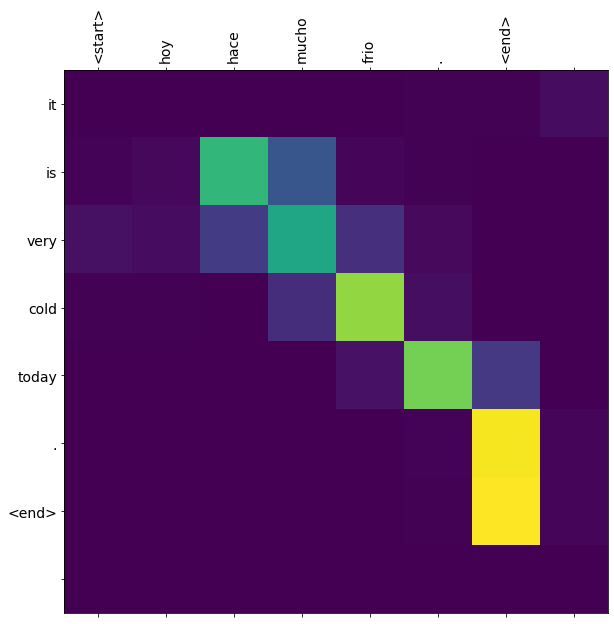

In [24]:
translate(u"Hoy hace mucho frío.")

In [25]:
translate(u"El número de usuarios de las aplicaciones aumentó considerablemente durante el período de la epidemia.")

KeyError: 'usuarios'